In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Contexte du test et du dataset :

Un exemple d'application du AB Testing est d'aider à trouver une meilleure approche pour trouver des clients, commercialiser des produits, obtenir une portée plus élevée, ou toute autre chose qui aide une entreprise à convertir la majorité de ses clients cibles en clients réels.

#### Voici toutes les features du jeu de données :

- **Campaign Name** : Le nom de la campagne
- **Date** : Date de l'enregistrement
- **Spend** : Montant dépensé pour la campagne en dollars
- **Impressions** : Nombre d'impressions que l'annonce a obtenues pendant la campagne
- **Reach** : Nombre d'impressions uniques reçues par l'annonce
- **Website Clicks** : Nombre de clics sur le site web reçus par les annonces
- **Searches** : Nombre d'utilisateurs ayant effectué des recherches sur le site
- **View Content** : Nombre d'utilisateurs ayant vu du contenu et des produits sur le site
- **Add to Cart** : Nombre d'utilisateurs ayant ajouté des produits au panier
- **Purchase** : Nombre d'achats

Deux campagnes ont été menées par l'entreprise :

- **Control Campaign** : Campagne de contrôle, avec les paramètres habituels
- **Test Campaign** : Campagne de test, avec les nouveaux paramètres


### **Importation et préparation des données**

In [29]:
control_df = pd.read_csv('control_group.csv', delimiter=';')
test_df = pd.read_csv('test_group.csv', delimiter=';')

full_df = pd.concat((control_df, test_df))

In [30]:
full_df.sample(n=5)

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
10,Control Campaign,11.08.2019,2490,115247.0,95843.0,8137.0,2941.0,2486.0,1887.0,475.0
27,Test Campaign,28.08.2019,2247,54627.0,41267.0,8144.0,2432.0,1281.0,1009.0,721.0
22,Test Campaign,23.08.2019,2407,60286.0,49329.0,5077.0,2592.0,2004.0,632.0,473.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,Control Campaign,22.08.2019,2939,105705.0,86218.0,6843.0,3102.0,2988.0,819.0,387.0


In [31]:
full_df = full_df.rename(
    columns=lambda x: x.replace("# of ", "") if x.startswith("# of ") else x)
full_df = full_df.rename(columns={"Campaign Name": "Campaign"})

full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 29
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Campaign        60 non-null     object 
 1   Date            60 non-null     object 
 2   Spend [USD]     60 non-null     int64  
 3   Impressions     59 non-null     float64
 4   Reach           59 non-null     float64
 5   Website Clicks  59 non-null     float64
 6   Searches        59 non-null     float64
 7   View Content    59 non-null     float64
 8   Add to Cart     59 non-null     float64
 9   Purchase        59 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 5.2+ KB


In [32]:
full_df[full_df.isnull().any(axis=1)]

,Campaign,Date,Spend [USD],Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchase
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
full_df = full_df.dropna()

full_df['Campaign'].value_counts()

Campaign
Test Campaign       30
Control Campaign    29
Name: count, dtype: int64

In [34]:
full_df.dtypes

Campaign           object
Date               object
Spend [USD]         int64
Impressions       float64
Reach             float64
Website Clicks    float64
Searches          float64
View Content      float64
Add to Cart       float64
Purchase          float64
dtype: object

In [35]:
full_df['Date'] = pd.to_datetime(full_df['Date'], format="%d.%m.%Y")
full_df[full_df.select_dtypes(include=['float64']).columns] = full_df.select_dtypes(include=['float64']).astype('int64')

full_df.dtypes

Campaign                  object
Date              datetime64[ns]
Spend [USD]                int64
Impressions                int64
Reach                      int64
Website Clicks             int64
Searches                   int64
View Content               int64
Add to Cart                int64
Purchase                   int64
dtype: object

In [36]:
full_df['Date'].dt.year.value_counts(), full_df['Date'].dt.month.value_counts()

(Date
 2019    59
 Name: count, dtype: int64,
 Date
 8    59
 Name: count, dtype: int64)

In [37]:
#Les données ont été récupérées sur le mois d'août 2019, on garde donc seulement le jour.
full_df["Date"] = full_df["Date"].dt.day
full_df.rename(columns={"Date": "Day"}, inplace=True)
full_df.head()

,Campaign,Day,Spend [USD],Impressions,Reach,Website Clicks,Searches,View Content,Add to Cart,Purchase
0,Control Campaign,1,2280,82702,56930,7016,2290,2159,1819,618
1,Control Campaign,2,1757,121040,102513,8110,2033,1841,1219,511
2,Control Campaign,3,2343,131711,110862,6508,1737,1549,1134,372
3,Control Campaign,4,1940,72878,61235,3065,1042,982,1183,340
5,Control Campaign,6,3083,109076,87998,4028,1709,1249,784,764


### **Traitement des outliers**

In [38]:
def any_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    limit_low = Q1 - 1.5*IQR
    limit_high = Q3 + 1.5*IQR

    not_outlier = df[col].between(limit_low, limit_high, inclusive='both').sum()

    outlier_percentage = (len(df[col]) - not_outlier)*100/len(df[col])

    return outlier_percentage

def remove_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    limit_low = Q1 - 1.5*IQR
    limit_high = Q3 + 1.5*IQR

    return df[df[col].between(limit_low, limit_high, inclusive='both')]

def plot_numeric(func):
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))
    axes = axes.flatten()

    numeric_cols = full_df.select_dtypes(include=['int']).columns.to_list()
    numeric_cols.remove('Day')

    for i, col in enumerate(numeric_cols):
        func(data=full_df, x='Campaign', y=col, ax=axes[i], hue='Campaign', palette={'Control Campaign': 'steelblue', 'Test Campaign': '#DAA520'}, legend=False)
        axes[i].set_title(col)
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()

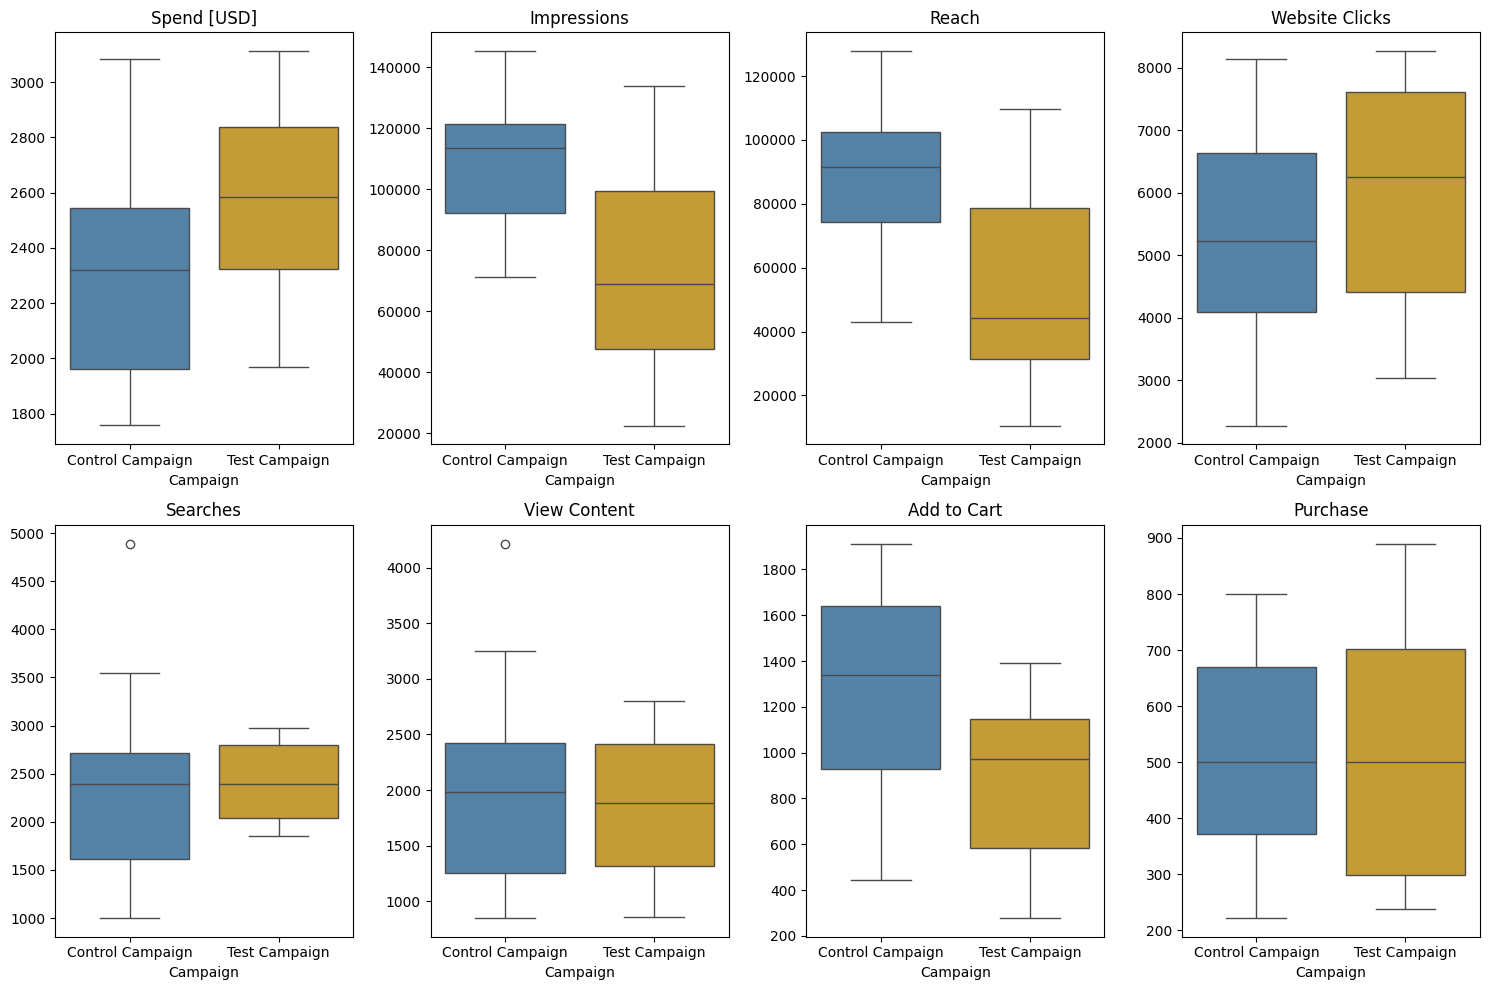

In [39]:
plot_numeric(sns.boxplot)

In [40]:
numeric_cols = full_df.select_dtypes(include=["int"]).columns.to_list()
numeric_cols.remove("Day")

outlier_percentages = {}
for col in numeric_cols:
    outlier_percentage = any_outlier(full_df, col)
    outlier_percentages[col] = outlier_percentage

outlier_df = pd.DataFrame(outlier_percentages.items(), columns=["Feature", "Outlier Percentage"])
outlier_df

,Feature,Outlier Percentage
0,Spend [USD],0.000000
1,Impressions,0.000000
2,Reach,0.000000
3,Website Clicks,0.000000
4,Searches,1.694915
5,View Content,1.694915
6,Add to Cart,0.000000
7,Purchase,0.000000


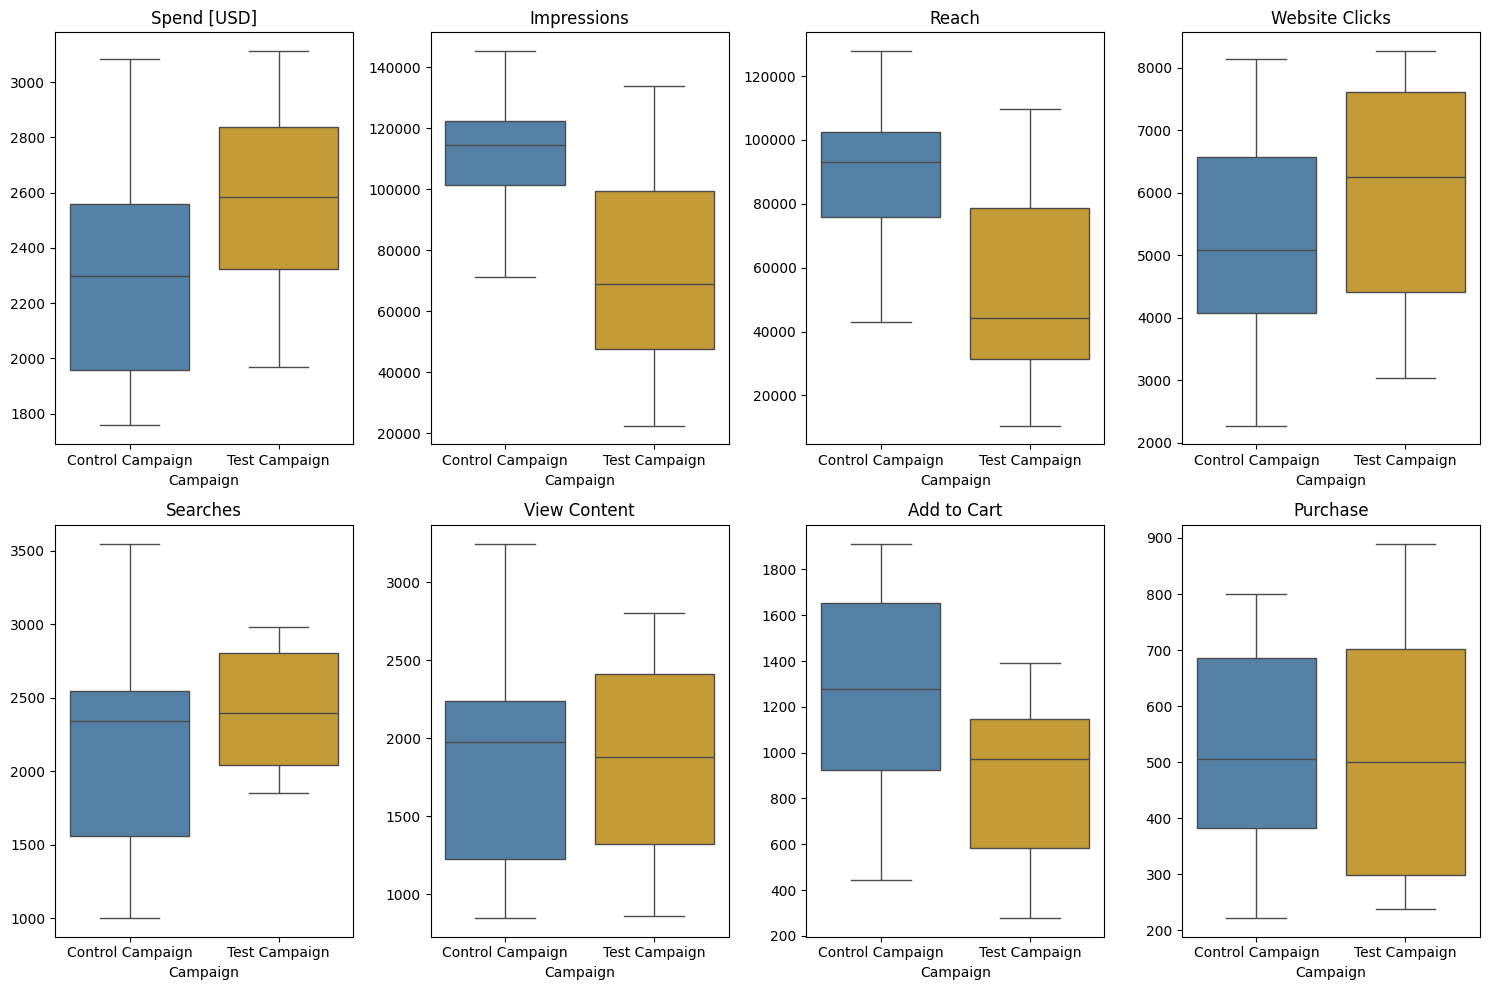

In [41]:
removable_outliers = outlier_df[outlier_df['Outlier Percentage'].between(0,3, inclusive='neither')]

for feature in removable_outliers.Feature :
    full_df = remove_outlier(full_df, feature)

plot_numeric(sns.boxplot)

### **Résumé des colonnes**

In [42]:
pd.set_option("display.max_columns", None)
full_df.drop(columns=["Day"]).groupby("Campaign").describe()

Spend [USD]                                                   \
                       count         mean         std     min     25%     50%   
Campaign                                                                        
Control Campaign        28.0  2301.535714  369.944989  1757.0  1956.5  2299.5   
Test Campaign           30.0  2563.066667  348.687681  1968.0  2324.5  2584.0   

                                  Impressions                               \
                      75%     max       count           mean           std   
Campaign                                                                     
Control Campaign  2557.00  3083.0        28.0  110185.857143  21818.408023   
Test Campaign     2836.25  3112.0        30.0   74584.800000  32121.377422   

                                                                    Reach  \
                      min        25%       50%        75%       max count   
Campaign                                                                    
Control Campaign  71274.0  101243.25  114338.5  122223.25  145248.0  28.0   
Test Campaign     22521.0   47541.25   68853.5   99500.00  133771.0  30.0   

                                                                          \
                          mean           std      min       25%      50%   
Campaign                                                                   
Control Campaign  89368.250000  22046.974382  42859.0  76022.25  93237.5   
Test Campaign     53491.566667  28795.775752  10598.0  31516.25  44219.5   

                                      Website Clicks               \
                        75%       max          count         mean   
Campaign                                                            
Control Campaign  102487.50  127852.0           28.0  5220.571429   
Test Campaign      78778.75  109834.0           30.0  6032.333333   

                                                                         \
                          std     min      25%     50%      75%     max   
Campaign                                                                  
Control Campaign  1703.130482  2277.0  4070.75  5082.5  6572.50  8137.0   
Test Campaign     1708.567263  3038.0  4407.00  6242.5  7604.75  8264.0   

                 Searches                                                   \
                    count         mean         std     min     25%     50%   
Campaign                                                                     
Control Campaign     28.0  2125.964286  710.276810  1001.0  1560.5  2340.0   
Test Campaign        30.0  2418.966667  388.742312  1854.0  2043.0  2395.5   

                                  View Content                           \
                      75%     max        count         mean         std   
Campaign                                                                  
Control Campaign  2543.00  3549.0         28.0  1862.535714  654.520208   
Test Campaign     2801.25  2978.0         30.0  1858.000000  597.654669   

                                                        Add to Cart  \
                    min     25%     50%     75%     max       count   
Campaign                                                              
Control Campaign  848.0  1224.0  1979.5  2239.5  3249.0        28.0   
Test Campaign     858.0  1320.0  1881.0  2412.0  2801.0        30.0   

                                                                         \
                         mean         std    min    25%     50%     75%   
Campaign                                                                  
Control Campaign  1293.357143  413.332636  442.0  924.5  1279.0  1654.5   
Test Campaign      881.533333  347.584248  278.0  582.5   974.0  1148.5   

                         Purchase                                        \
                     max    count        mean         std    min    25%   
Campaign                                                                  
Control

### **Analyse des corrélations**

<Axes: >

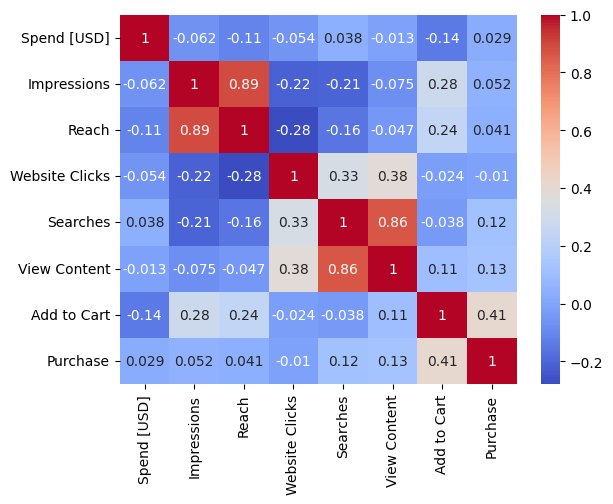

In [43]:
mat_corr = full_df.drop(columns=["Campaign", "Day"]).corr()
sns.heatmap(mat_corr, annot=True, cmap="coolwarm")

### **Interprétation des corrélations**

 * On peut extraire deux couples de variables fortement corrélées : 
    - Reach & Impressions
    - Searches & View Content

*Cependant, Reach et Impressions désignent respectivement le nombre de personnes (unique) atteintes et le nombre d'impressions.*

 * Corrélation très faible entre Spend et Purchase :

*Ceci semble indiquer que dépenser plus pour une campagne n'augmenterait pas nécessairement le nombre d'achats.*

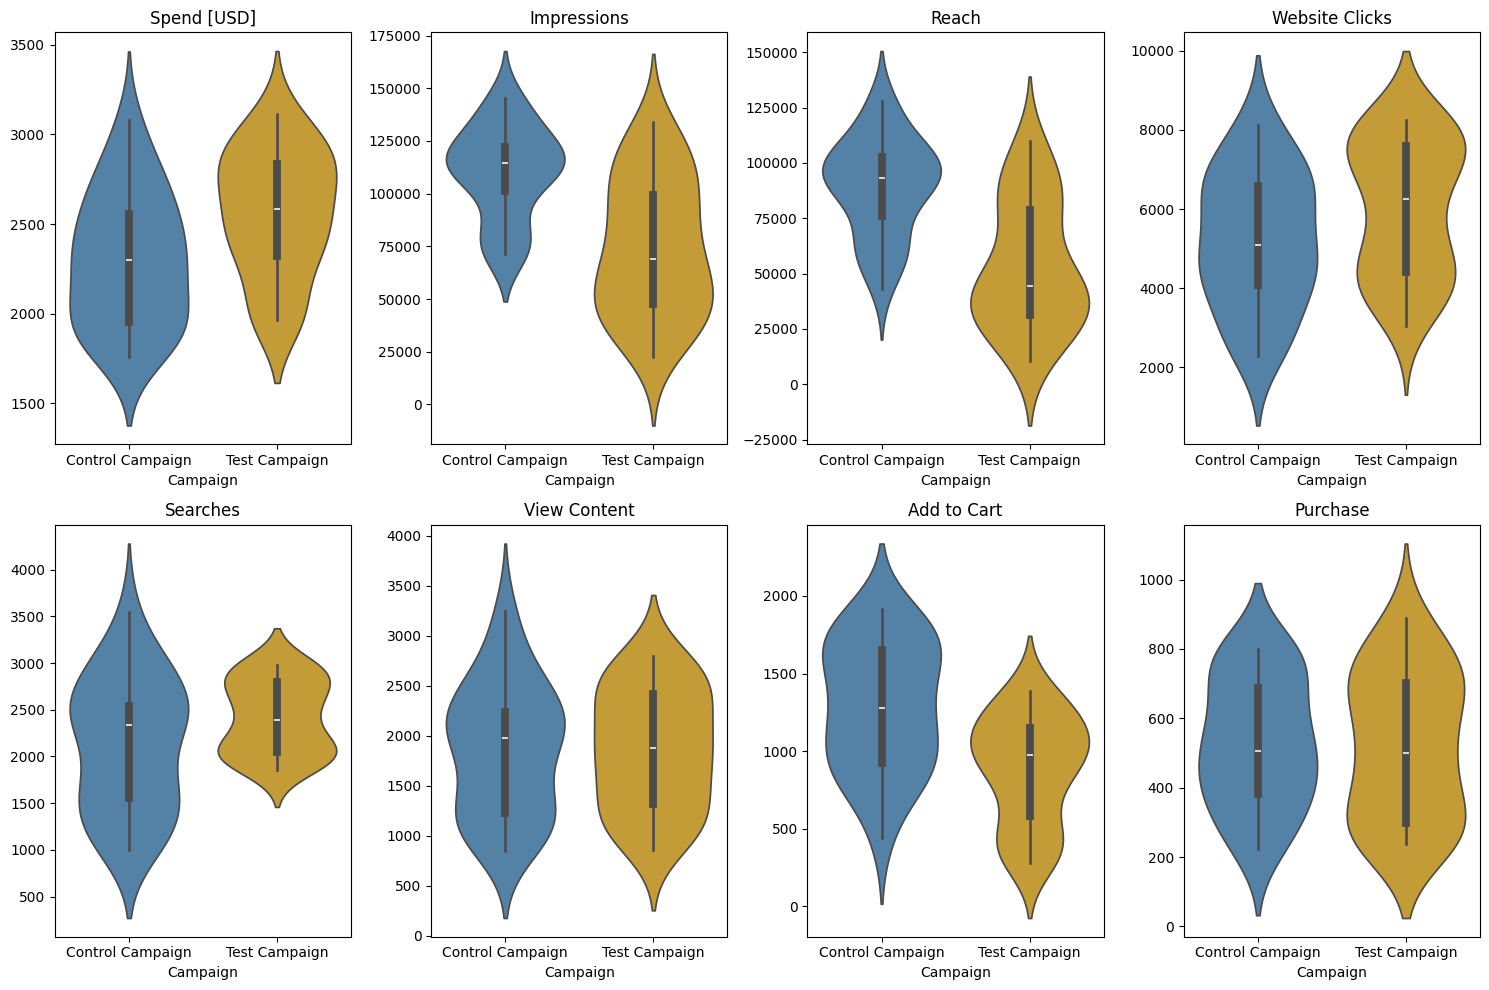

In [44]:
plot_numeric(sns.violinplot)

### **Interprétation des diagrammes en violon**


##### Spend [USD]:

* Les deux distributions sont bien différentes, avec une médiane plus élevée pour la campagne de test.
* La dispersion semble élevée dans les deux groupes, ce qui indique une large gamme de dépense.

##### Impressions:

* La médiane est plus élevée pour la campagne de contrôle.
* La dispersion de la campagne de test est grande, et est plus dense dans les valeurs plus faibles.

##### Reach:

* Similaire à 'Impressions' ce qui conforte l'idée énoncée précédemment.

##### Website Clicks:

* La campagne de test à l'air de mieux convertir en taux de clicks.

##### Searches :

* Médianes équivalentes et dispersion plus faible pour la campagne de test.

##### Add to Cart:

* Malgré un taux de 'Website clicks' plus élevé, on observe une légère baisse sur ce critère.

##### Purchase (Intérêt ici):

* On remarque que malgré la baisse de 'Reach', les valeurs de 'Purchase' restent globalement similaires.
* Premier quartile un légèrement plus faible.


### **Conclusion de l'interprétation avant Test statistique**

On peut imaginer que la campagne de test se base sur des dépenses plus élévées ('Spend [USD]'), mais cela ne semble pas affecter positivement les centres d'intérêt ici, à savoir les impressions uniques ('Impressions') et le nombre de vente ('Purchase').

### **Test statistique n°1 (Hoeffding):**

#### Test n°1 : Implémentation du Test créé lors du projet

In [45]:
def HoeffdingT(cols, delta, df=full_df, t=1.358102):
    c_df = df[df['Campaign'] == 'Control Campaign'].copy()
    t_df = df[df['Campaign'] == 'Test Campaign'].copy()

    nA = c_df['Reach'].sum() #Nombre de personnes ayant vu la campagne de contrôle
    nB = t_df['Reach'].sum() #Nombre de personnes ayant vu la campagne de test

    res = []

    for i, col in enumerate(cols):
        hatPA = c_df[col].sum()/nA
        hatPB = t_df[col].sum()/nB
    
        threshold = hatPA + delta[i] + t * (1 / np.sqrt(nA) + 1 / np.sqrt(nB))

        decision = "On choisit la campagne de contrôle" if hatPB <= threshold else "On choisit la campagne de test"

        res.append([col, hatPA, hatPB, threshold, decision])

    return res

In [46]:
res_obt = HoeffdingT(['Purchase', 'Website Clicks', 'Add to Cart'], [0.0003, 0.003, 0.00075]) 
#On prend ici delta = 5% du pA observé

for var in res_obt:
    print(f'Variable : {var[0]} || Décision : {var[4]}')

Variable : Purchase || Décision : On choisit la campagne de test
Variable : Website Clicks || Décision : On choisit la campagne de test
Variable : Add to Cart || Décision : On choisit la campagne de contrôle


#### **Conclusion (Test n°1):**

* *Purchase ->* Le test indique qu'il vaut mieux choisir la campagne de test.

* *Website Clicks ->* Le test indique qu'il vaut mieux choisir la campagne de test.

* *Add to Cart ->* Le test indique qu'il vaut mieux choisir la campagne de contrôle.

#### Test n°2 : Comparaison des résultats obtenus avec le Test t :
Pour la suite, on va utiliser le Test t (resp. le test Mann-Whitney U) si la variable à tester est gaussienne (resp. non gaussienne). On utilise aussi le test de Levene pour déterminer si les variances sont homogènes ou non.

##### *Implémentation du Test t*

##### Hypothèses du test t :

**-> Purchase**
* H₀ (hypothèse nulle) : Il n'y a pas de différence significative entre les taux de conversion des deux campagnes.

* H₁ (hypothèse alternative) : Les taux de conversion de la campagne de test est plus grande que celle de contrôle.


**-> Website Clicks**
* H₀ (hypothèse nulle) : Il n'y a pas de différence significative entre les taux de clicks des deux campagnes.

* H₁ (hypothèse alternative) : Les taux de conversion des deux campagnes sont différentes.


**-> Add to Cart**
* H₀ (hypothèse nulle) : Il n'y a pas de différence significative entre les taux de mise en panier des deux campagnes.

* H₁ (hypothèse alternative) : Le taux d'ajout au panier de la campagne de contrôle est plus élevé.

In [47]:
def check_normality(col, alpha=0.05):
    stat, p = stats.shapiro(col) #On utilise shapiro car nous n'avons pas beacoup de données (n<50)

    if p < alpha:
        return "Not Normal"
    return "Normal"

In [48]:
def test_T(cols, df=full_df, alt='two-sided'):
    c_df = df[df['Campaign'] == 'Control Campaign'].copy()
    t_df = df[df['Campaign'] == 'Test Campaign'].copy()

    res = []

    for i, col in enumerate(cols):

        if check_normality(c_df[col]) == "Normal" and check_normality(t_df[col]) == "Normal":
            stat, p_lev = stats.levene(c_df[col], t_df[col])
            equal_var = p_lev > 0.05

            stat, p_value = stats.ttest_ind(c_df[col], t_df[col], equal_var=equal_var, alternative=alt[i])
        else:
            stat, p_value = stats.mannwhitneyu(c_df[col], t_df[col], alternative=alt[i])

        decision = "Rejetter H0" if p_value < 0.05 else "Ne pas rejetter H0"

        res.append([col, stat, p_value, decision])

    

    return res      

In [49]:
res_comp = test_T(['Purchase', 'Website Clicks', 'Add to Cart'], alt=['less', 'two-sided', 'greater'])

for var in res_comp:
    print(f'Variable : {var[0]} || Décision : {var[3]}')

Variable : Purchase || Décision : Ne pas rejetter H0
Variable : Website Clicks || Décision : Ne pas rejetter H0
Variable : Add to Cart || Décision : Rejetter H0


#### **Conclusion (Test n°2):**

* *Purchase ->* Le test indique qu'il n'y a pas de différence significative entre la campagne de contrôle et celle de test. Donc on choisit celle de contrôle.

* *Website Clicks ->* Le test indique qu'il n'y a pas de différence significative entre la campagne de contrôle et celle de test. Donc on choisit celle de contrôle.

* *Add to Cart ->* Le taux d'ajout au panier de la campagne de contrôle est plus élevée. Donc on choisit celle de contrôle.

## **Résumé des Tests**

On conclut finalement que notre test est plus adapté si une des deux campagnes n'est pas encore mise en place.
En effet, on ne remarque pas ici de différence significative avec les tests classiques, ce qui explique que changer toute une campagne ne serait pas très avantageux pour si peu de gain.
À l'inverse, si aucune campagne n'est déjà mise en place, il peut être intéressant de relevé les petites différences, d'où l'intérêt de notre test.

Voici un tableau récapitulatif de cette application :

| Critère                     | Test maison (Hoeffding-like)                                           | Test classique (t-test / Mann-Whitney)                     |
|----------------------------|------------------------------------------------------------------------|-------------------------------------------------------------|
| **Objectif**               | Décision pragmatique : *choisir entre deux options avec un seuil*     | Détection d'une différence significative                   |
| **Contrôle sur l'incertitude** | *delta* explicite et interprétable                             | Seuil alpha implicite basé sur la p-valeur                  |
| **Interprétation business**| Très claire ("choisir A ou B selon le seuil")                          | Moins intuitive                                             |
| **Hypothèses**             | Aucune ou très peu                                                    | Normalité, égalité des variances, etc.                     |                               |
